<a href="https://colab.research.google.com/github/iotanalytics/IoTTutorial/blob/main/code/clustering_and_classification/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Gaussian Mixture Model (GMM)** [Unsupervised]
*Author: Kayvon Ghahremani*

*Updated: Stephen Coshatt*

<br/>

"Gaussian mixture models are a probabilistic model for representing normally distributed subpopulations within an overall population. Mixture models in general don't require knowing which subpopulation a data point belongs to, allowing the model to learn the subpopulations automatically. Since subpopulation assignment is not known, this constitutes a form of unsupervised learning." [2]

*Motivation*:

"One hint that data might follow a mixture model is that the data looks multimodal, i.e. there is more than one "peak" in the distribution of data. Trying to fit a multimodal distribution with a unimodal (one "peak") model will generally give a poor fit. For several theoretical reasons, the most commonly used distribution in modeling real-world unimodal data is the Gaussian distribution. Thus, modeling multimodal data as a mixture of many unimodal Gaussian distributions makes intuitive sense. Furthermore, GMMs maintain many of the theoretical and computational benefits of Gaussian models, making them practical for efficiently modeling very large datasets." [2]

Gaussian mixture model is a function that is comprised of several Gaussians, each identified by k ∈ {1,…, K}, where K is the number of clusters of our dataset. Each Gaussian k in the mixture is comprised of the following parameters:
*   A mean μ that defines its centre.
*   A covariance Σ that defines its width. This would be equivalent to the dimensions of an ellipsoid in a multivariate scenario.
*   A mixing probability π that defines how big or small the Gaussian function will be.

Pros:
*   Compared to k-means, GMM is a lot more flexible in terms of cluster covariance and assigning clusters. 
    *   With GMM each cluster can have unconstrained covariance structure, so instead of just spherical clusters GMM can have rotated and/or elongated clusters.
*   GMM allows for mixed membership of points to clusters. 
    *   In k-means, a point belongs to one and only one cluster, whereas in GMM a point belongs to each cluster to a different degree based on probability.

Cons:
*   Longer computation time.
*   Having to decide K beforehand.
*   The data needs to be similar to a normal distribution.
*   The more uneven cluster sizes are, the higher the error rate is.
    *   If there is large difference between the size of the clusters then error rate might be significant.


**References:**

1.   https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

2.   https://brilliant.org/wiki/gaussian-mixture-model/

### Models [2]:

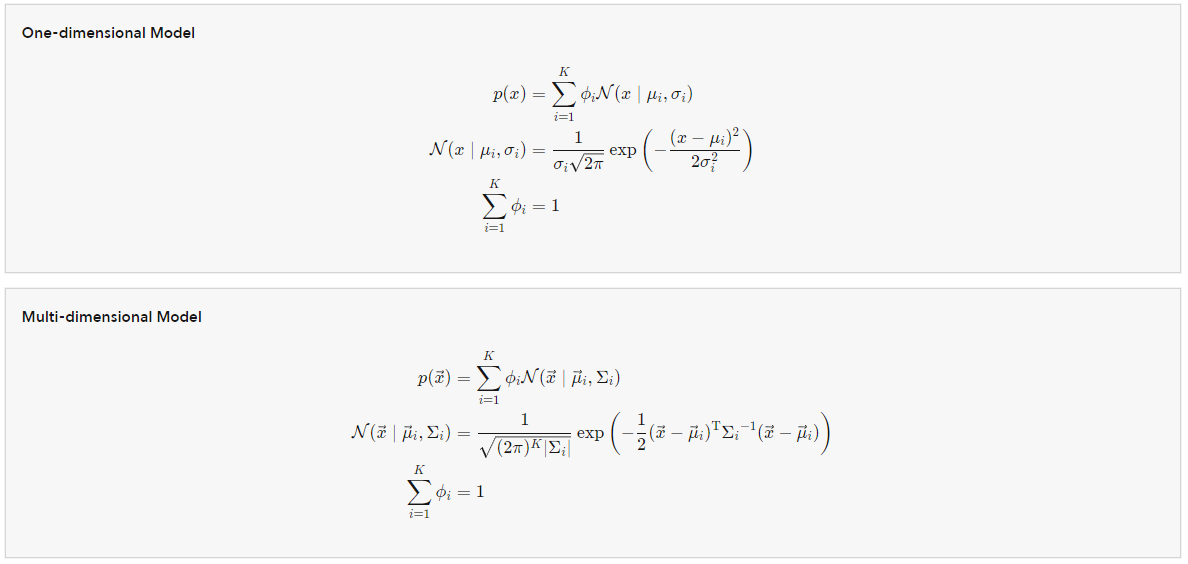

### GMM Steps [2]:

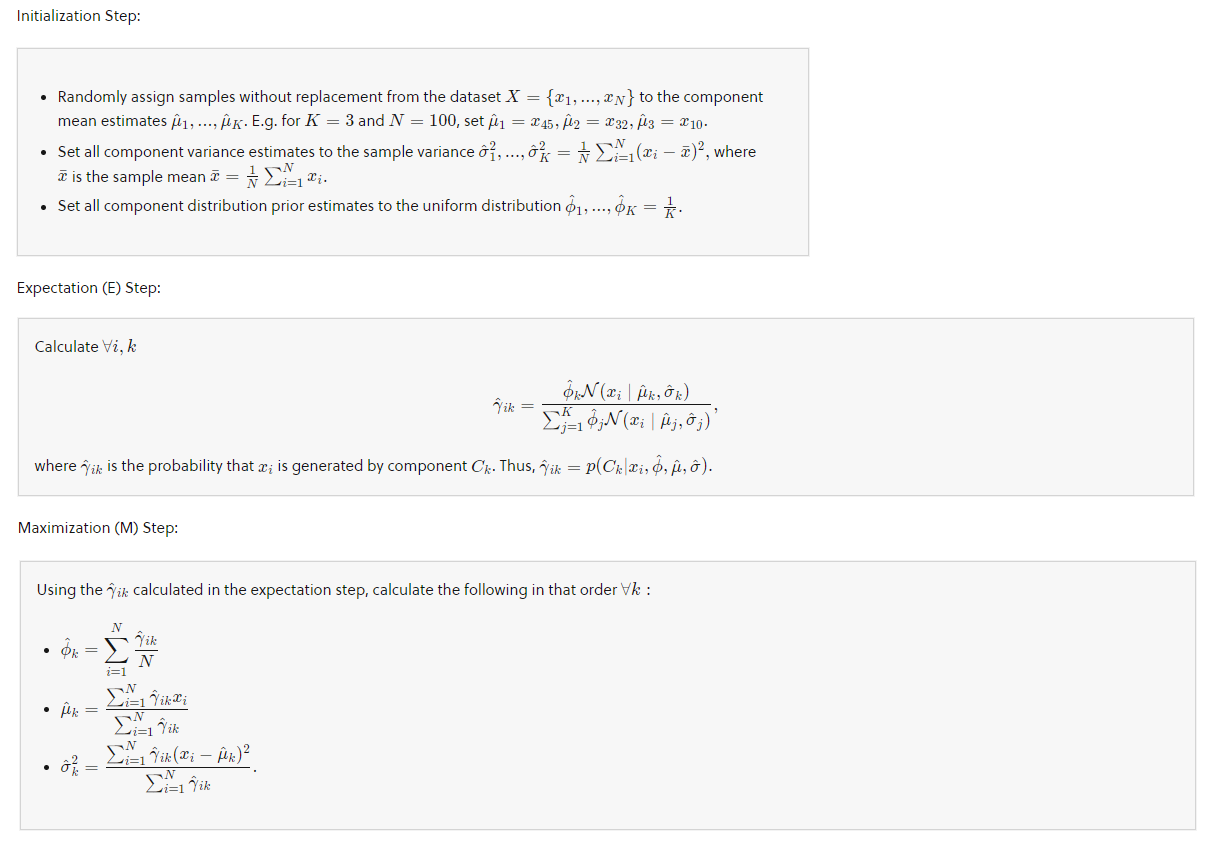

 ### ***Choosing the covariance type***

If you look at the details of the preceding fits, you will see that the ``covariance_type`` option was set differently within each.
This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
The default is ``covariance_type="diag"``, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
A slightly simpler and faster model is ``covariance_type="spherical"``, which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use ``covariance_type="full"``, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

We can see a visual representation of these three choices for a single cluster within the following figure:

![picture](https://drive.google.com/uc?export=view&id=1S70qrZj8RHPn0pIx2B6PvlL_YfIyvouw)

In [5]:
!pip install influxdb

     |████████████████████████████████| 77 kB 4.3 MB/s 


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Text(0.5, 0, 'Time')

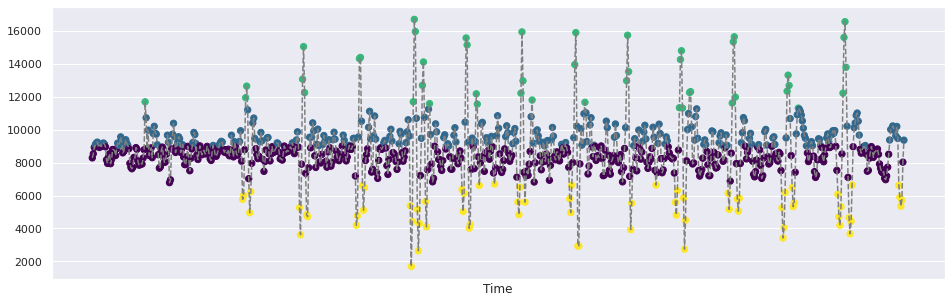

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

import csv
import pywt
from influxdb import InfluxDBClient
import operator
import scipy.signal as sg
import scipy as sp
import sklearn


import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np


ip = "sensorweb.us" 
unit = "b8:27:eb:76:15:20" # FloorB
stampIni = "2020-07-07T19:18:14.000Z" # UTC time = EST time + 4
stampEnd = "2020-07-07T19:18:22.000Z"
client = InfluxDBClient(ip, "8086", "test", "sensorweb", "shake",ssl=True)
# Check FloorB at http://3.136.84.223:3000/d/3HdIpxGMz/s-house-dashboard-raw-data-only?orgId=1&from=1594149493945&to=1594149503005

query = 'SELECT "value" FROM Z WHERE ("location" = \''+unit+'\')  and time >= \''+stampIni+'\' and time <= \''+stampEnd+'\'   '
result = client.query(query)
points = list(result.get_points())
values =  map(operator.itemgetter('value'), points)
times  =  map(operator.itemgetter('time'),  points)
data = np.array(list(values))
times1 = np.array(list(times))
if(len(data) == 0):
  print("No data in the chosen time range!")
  quit()

# from sklearn.datasets.samples_generator import make_blobs
# X, y_true = make_blobs(n_samples=400, centers=4,
#                        cluster_std=0.60, random_state=0)
# X = X[:, ::-1] # flip axes for better plotting

from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(data.reshape(-1,1))
labels3 = gmm.predict(data.reshape(-1,1))
fig = plt.figure(figsize=(16,5))
plt.scatter(times1, data, c=labels3, s=40, cmap='viridis')
plt.xticks([],rotation=45)
plt.plot(times1,data,'--',c='grey')
plt.xlabel('Time')

In [7]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(times1, data, c=labels3, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(times1, data, s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    # for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    #     draw_ellipse(pos, covar, alpha=w * w_factor)